### It turns out that Epoch = 3, Batch Size = 8 , Learning Rate = 5e-5 performs well (without overfitting)

In [1]:
import numpy as np
import time
import json
import os
import pandas as pd
import re

from datasets import Dataset
from transformers import AutoTokenizer
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
from transformers import DefaultDataCollator

ModuleNotFoundError: No module named 'datasets'

In [4]:
BERT_MODEL = "bert-base-uncased"
#BERT_MODEL = "vinai/bertweet-base"
NUM_EPOCHS = 6
BATCH_SIZE = 20
DROPOUT = 0.2

## Load Data into Pandas DF

In [5]:
## Load data

TRAIN_DATA_PATH = "./full_data/data_storage/full_dev_train.json"
Y_TRAIN_ID_PATH = "./id_data/train.label.txt"
X_TRAIN_ID_PATH = "./id_data/train.data.txt"   # train

DEV_DATA_PATH = "./full_data/data_storage/full_dev_train.json"
Y_DEV_ID_PATH = "./id_data/dev.label.txt"
X_DEV_ID_PATH = "./id_data/dev.data.txt"   # dev

TEST_DATA_PATH = "./full_data/data_storage/test_full_v2.json"
X_TEST_ID_PATH = "./id_data/test.data.txt"   # test

In [4]:
## Import Twitter Processer
#!pip install tweet-preprocessor

import preprocessor as p
i = "@Telegraph How \n\n very sad. @Telegraph @Telegraph"
p.clean(i)

'How very sad.'

In [6]:
def convert_replies_id_to_sorted_text(list_of_id, data_df):
    """Convert a list of tweet ids to a list of its corresponding text in data_df
    Sort by tweets original create time"""
    if type(list_of_id) is not list:
        # if input is a single id convert type
        list_of_id = [list_of_id]
    # Select dataframe based on a list of ids
    selected_df = data_df[data_df['id'].astype(str).isin(list_of_id)]
    # Sort by their created time
    sorted_df = selected_df.sort_values(by = ["created_at"])
    # Select text fields only
    text_list = sorted_df["text"].to_list()
    return text_list


def remove_URL(original):
    """Remove url link in the text"""
    result = re.sub(r"http\S+", "", original)
    result = re.sub(r"www.\S+", "", result)
    result = re.sub(r"wasap.my+", "", result)
    return result

def join_data_id_label_v2(LABEL_PATH, ID_PATH, DATA_PATH):
    # Process Labels
    if LABEL_PATH:
        # 1: Rumour
        # 0: NonRumour
        with open(LABEL_PATH, "r") as f:
            y_label = f.read().strip().split("\n") # remove next line
        y_label = pd.DataFrame(y_label, columns = ["label"])
        y_label[y_label["label"]=="rumour"] = 1
        y_label[y_label["label"]=="nonrumour"] = 0

    ## Get Dataframe Id, with first id as source Id, and values as replies, not using dict since we have duplicated keys
    total_id_list = []
    with open(ID_PATH, "r") as f:
        for line in f:
            line = line.strip().split(',') # remove next line
            source_id = line[0]
            if len(line) > 1:
                # if we have replies id
                replies_id = line[1:]
            else:
                replies_id = []
            row = [source_id, replies_id]
            total_id_list.append(row)
    len(total_id_list)
    
    ## Create a dataframe containing a list of replies
    source_df = pd.DataFrame(total_id_list, columns = ['source_id', 'replies_id'])
    data_df = pd.read_json(DATA_PATH)
    source_df["reply_text_list"] = source_df["replies_id"].apply(convert_replies_id_to_sorted_text, data_df = data_df)
    source_df["source_text"] = source_df["source_id"].apply(convert_replies_id_to_sorted_text, data_df = data_df)

    if LABEL_PATH:
      source_df["label"] = y_label
    return source_df

def bert_preprocess(IDS, DATA, LABELS=False):
    """Function to combine all the preprocessing steps"""
    data = join_data_id_label_v2(LABELS, IDS, DATA)
    ## 1. Only keep english tweets as most of them are in english
    # Use only text data and remove URLs
    #data["source"] = data["source_text"].apply(" ".join).apply(p.clean) 
    #data["replies"] = data["reply_text_list"].apply(" ".join).apply(p.clean)
    data["source"] = data["source_text"].apply(" ".join)
    data["replies"] = data["reply_text_list"].apply(" ".join)
    
    
    if LABELS:
      data = data[['source','replies','label']]
    else:
      data = data[['source','replies']]
    
    return data

In [7]:
## Keep only source text as a column AND concatenated reply strings as another column
data_train = bert_preprocess(X_TRAIN_ID_PATH, TRAIN_DATA_PATH, LABELS=Y_TRAIN_ID_PATH)
data_train

,source,replies,label
0,5. Can regularly rinsing your nose with saline...,4. Can eating garlic help prevent infection wi...,0
1,French police chief killed himself after #Char...,@Telegraph How very sad. @Telegraph @Telegraph...,1
2,Coronavirus disease (COVID-19) advice for the ...,Infection control for suspected or confirmed C...,0
3,Ottawa police confirm that there were multiple...,@WSJ Killers go berserk when cornered. Hencef...,0
4,if the primary focus of a government isn't to ...,,0
...,...,...,...
1890,Desperate Ted Cruz Claims Planned Parenthood S...,@Bipartisanism \nDesperate! @Bipartisanism Cr...,1
1891,"""Thoughts and prayers are not enough."" Pres. O...",.@ABC has anyone else noticed mass shootings s...,1
1892,Police have surrounded this building where the...,@NBCNews bury them in their hole @NBCNews @Wik...,0
1893,,@Kirstenjoyweiss @MattFabrication @prestone85 ...,0


In [8]:
## Keep only source text as a column AND concatenated reply strings as another column
data_dev = bert_preprocess(X_DEV_ID_PATH, DEV_DATA_PATH, LABELS=Y_DEV_ID_PATH)
data_dev

,source,replies,label
0,COVID-19 Fact:\nAre hand dryers effective in k...,"@WeatherBug They are, in fact, germ-breeding f...",0
1,@atruchecks when can we expect the result of m...,@ewart_lynne @atruchecks Hi have you had any l...,0
2,How does COVID-19 spread? \n\nPeople can catch...,I've read a lot about Corona virus lately and ...,0
3,"every news outlet using headlines like,\n\n""ar...","@TuckyAalto Apparently, when a headline is a q...",0
4,Researcher @naskrecki on his encounter with a ...,@Harvard @naskrecki eu tenho uma dessas em cas...,0
...,...,...,...
627,"or cure for COVID-19. However, there are sever...",WHAT ARE THE TREATMENT OPTIONS FOR COVID-19 (I...,0
628,"After speculation that he’s been arrested, Ban...",@artnet @xklamation there was a story saying s...,1
629,*Your questions answered*❓\n\n*Reply with the ...,s?\n\n14. Can I catch COVID-19 from infected s...,0
630,"►#Anonymous Operation #KKK ►Ku Klux Klan, We n...",@AnonymousVideo https://t.co/84M8wTOAoM @grann...,1


In [9]:
data_dev.to_csv("./bert_data/trunc_data_dev.csv")

In [10]:
data_train.to_csv("./bert_data/trunc_data_train.csv")

## Convert Pandas Dataframe to Transformer DataSet

In [8]:
dataset_train = Dataset.from_pandas(data_train)
dataset_train

Dataset({
    features: ['source', 'replies', 'label'],
    num_rows: 1895
})

In [9]:
dataset_dev = Dataset.from_pandas(data_dev)
dataset_dev

Dataset({
    features: ['source', 'replies', 'label'],
    num_rows: 632
})

In [10]:
total_train = pd.concat([data_dev,data_train], axis=0)
dataset_total_train = Dataset.from_pandas(total_train)

## Transformer Dataset to TensorFlow TF Dataset

Makin use of Transformer Dataset

In [11]:
## Set up Tokenizer


tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, normalization=True)

## Tokenize with two sentences separated by [SEP]m, use source and reply as two sentences
def tokenize_function(dataset):
    return tokenizer(dataset["source"], dataset["replies"], padding="max_length", truncation=True)

# Set up Train data
tokenized_train_datasets = dataset_train.map(tokenize_function, batched=True)
# Set up Dev Data
tokenized_dev_datasets = dataset_dev.map(tokenize_function, batched=True)


# Set up Total Data
tokenized_total_datasets = dataset_total_train.map(tokenize_function, batched=True)


100%|██████████| 3/3 [00:00<00:00,  6.96ba/s]


In [12]:
## Use data_collator to batch the dataset
data_collator = DefaultDataCollator(return_tensors="tf")

In [13]:
tf_train_dataset = tokenized_train_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

tf_validation_dataset = tokenized_dev_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)



tf_totaltrain_dataset = tokenized_total_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

2022-05-09 13:18:07.556081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 13:18:07.577223: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 13:18:07.577325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 13:18:07.577983: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Tensor Flow Bert Model

Use Training Set to train and test against dev set

In [14]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [15]:
# https://stackoverflow.com/questions/52041931/is-there-an-optimizer-in-keras-based-on-precision-or-recall-instead-of-loss
from keras import backend as K
THRESHOLD = 0.5
def precision(y_true, y_pred, threshold_shift=0.5-THRESHOLD):

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))

    precision = tp / (tp + fp)
    return precision


def recall(y_true, y_pred, threshold_shift=0.5-THRESHOLD):

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fn = K.sum(K.round(K.clip(y_true - y_pred_bin, 0, 1)))

    recall = tp / (tp + fn)
    return recall


def fbeta(y_true, y_pred, beta = 2, threshold_shift=0.5-THRESHOLD):   
    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall) 


In [16]:


## Define Model
# model = TFAutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2,
#         attention_probs_dropout_prob=DROPOUT,
#         hidden_dropout_prob=DROPOUT)

model = TFAutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2)


## Set up optimisation method, minimise which loss
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=tf.metrics.SparseCategoricalAccuracy(),
# )

# Use f1 score to capture information
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.metrics.SparseCategoricalAccuracy(), fbeta,precision,recall]
)


2022-05-09 13:18:11.430368: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Fit model
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=NUM_EPOCHS)


Epoch 1/6


2022-05-09 13:18:28.801026: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 120.00MiB (rounded to 125829120)requested by op tf_bert_for_sequence_classification/bert/encoder/layer_._4/intermediate/Gelu/Erf
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-05-09 13:18:28.801116: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-05-09 13:18:28.801140: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 112, Chunks in use: 110. 28.0KiB allocated for chunks. 27.5KiB in use in bin. 810B client-requested in use in bin.
2022-05-09 13:18:28.801154: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B clien

ResourceExhaustedError: Graph execution error:

Detected at node 'tf_bert_for_sequence_classification/bert/encoder/layer_._4/intermediate/Gelu/Erf' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/lee/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/lee/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/lee/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/lee/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/lee/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/home/lee/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/home/lee/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/home/lee/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/home/lee/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/lee/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "/home/lee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "/home/lee/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/lee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/lee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/lee/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3907/2888595672.py", line 2, in <cell line: 2>
      model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=NUM_EPOCHS)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/lee/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/lee/.local/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 996, in train_step
      y_pred = self(x, training=True)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1619, in run_call_with_unpacked_inputs
      >>> model = TFBertModel.from_pretrained("./test/saved_model/")
    File "/home/lee/.local/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 1633, in call
      outputs = self.bert(
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1619, in run_call_with_unpacked_inputs
      >>> model = TFBertModel.from_pretrained("./test/saved_model/")
    File "/home/lee/.local/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 850, in call
      encoder_outputs = self.encoder(
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 535, in call
      for i, layer_module in enumerate(self.layer):
    File "/home/lee/.local/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 541, in call
      layer_outputs = layer_module(
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 497, in call
      intermediate_output = self.intermediate(hidden_states=attention_output)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/lee/.local/lib/python3.10/site-packages/transformers/models/bert/modeling_tf_bert.py", line 401, in call
      hidden_states = self.intermediate_act_fn(hidden_states)
    File "/home/lee/.local/lib/python3.10/site-packages/keras/activations.py", line 351, in gelu
      return tf.nn.gelu(x, approximate)
Node: 'tf_bert_for_sequence_classification/bert/encoder/layer_._4/intermediate/Gelu/Erf'
failed to allocate memory
	 [[{{node tf_bert_for_sequence_classification/bert/encoder/layer_._4/intermediate/Gelu/Erf}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_23623]

Text(0.5, 1.0, 'Train VS DEV accuracy, Learning_Rate = 5e-5')

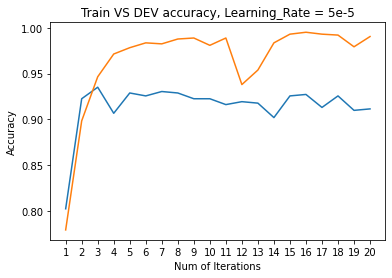

In [ ]:
import matplotlib.pyplot as plt

train_acc = [0.7791, 0.8983, 0.9465, 0.9714, 0.9783, 0.9836, 0.9825, 0.9878, 0.9889, 0.9809, 0.9889, 0.9380, 0.9539, 0.9836, 0.9931, 0.9952, 0.9931, 0.9921, 0.9793, 0.9905]
dev_acc = [0.8022, 0.9225, 0.9351, 0.9066, 0.9288, 0.9256, 0.9304, 0.9288, 0.9225, 0.9225, 0.9161, 0.9193, 0.9177, 0.9019, 0.9256, 0.9272, 0.9130, 0.9256, 0.9098, 0.9114]

x = range(1, len(train_acc)+1)
plt.rcParams['figure.dpi'] = 200

plt.plot(x, dev_acc)
plt.plot(x, train_acc)
plt.xticks(range(1, len(train_acc)+1))

plt.xlabel("Num of Iterations")
plt.ylabel("Accuracy")

plt.title("Train VS DEV accuracy, Learning_Rate = 5e-5")

## Train using Train + Dev Set

In [ ]:
# Fit model
#model.fit(tf_totaltrain_dataset, validation_data=tf_validation_dataset, epochs=NUM_EPOCHS)


Epoch 1/4
315/315 [==============================] - 102s 284ms/step - loss: 0.3339 - sparse_categorical_accuracy: 0.8492 - val_loss: 0.1402 - val_sparse_categorical_accuracy: 0.9494
Epoch 2/4
315/315 [==============================] - 93s 294ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.9504 - val_loss: 0.0735 - val_sparse_categorical_accuracy: 0.9778
Epoch 3/4
315/315 [==============================] - 93s 296ms/step - loss: 0.0943 - sparse_categorical_accuracy: 0.9679 - val_loss: 0.0865 - val_sparse_categorical_accuracy: 0.9684
Epoch 4/4
315/315 [==============================] - 93s 296ms/step - loss: 0.0649 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.0211 - val_sparse_categorical_accuracy: 0.9953


## Test on Test Set

In [ ]:
test_df = bert_preprocess(X_TEST_ID_PATH, TEST_DATA_PATH)
test_dataset = Dataset.from_pandas(test_df)  # Convert to Transformer Dataset

In [ ]:
# Convert to Keras input for Bert model
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True)
tf_test_dataset = tokenized_test_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

100%|██████████| 1/1 [00:00<00:00, 10.22ba/s]


In [ ]:
y_pred = model.predict(tf_test_dataset)

In [ ]:
# generate the csv for prediction
def generate_csv(pred, csv_name):
    ids = pd.Index(range(len(pred)), name='Id')
    predictions = pd.DataFrame(pred, index=ids)
    predictions.columns = ['Predicted']
    predictions.to_csv(csv_name)

def model_output_to_label(model_output):
    """Conver the output class of a tensorflow model to label"""
    logit_df = pd.DataFrame(model_output.to_tuple()[0], columns = ["0","1"])
    ## Choose highest logit as the predicted class
    logit_df["label"] = logit_df.apply(lambda x: 0 if x["0"] > x["1"] else 1, axis=1)
    return logit_df["label"]

In [ ]:
labels = model_output_to_label(y_pred)
generate_csv(labels, "./output/vanillabertmodel.csv")